In [ ]:
%pip install scikit-fuzzy

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skfuzzy as fuzz
import os
import glob
import pandas as pd
import warnings
warnings.filterwarnings('ignore')  # Suppress some sklearn warnings

Get paths to WBC images from the dataset.
Distributes max_images across cell types.

Keep only the largest connected component in a binary mask.


Compute the overlap of edges between original and segmented images.
Higher value (0-1) means segmented boundaries better match original edges.

    Segments a WBC image into background, cytoplasm, and nucleus
    using K-Means and Fuzzy C-Means.
    
    Returns:
        img_rgb: original RGB image
        km_result: K-Means segmented image (RGB)
        fcm_result: FCM segmented image (RGB)
        km_nucleus_mask: binary mask for nucleus (K-Means)
        fcm_nucleus_mask: binary mask for nucleus (FCM)
        km_cyto_mask: binary mask for cytoplasm (K-Means)
        fcm_cyto_mask: binary mask for cytoplasm (FCM)

In [ ]:
def get_image_paths(dataset_path, cell_types=['NEUTROPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'EOSINOPHIL'], max_images=10):

    image_paths = []
    for cell_type in cell_types:
        pattern = os.path.join(dataset_path, '**', cell_type, '*.jpeg')
        paths = glob.glob(pattern, recursive=True)
        # Take a balanced subset
        n_per_type = max_images // len(cell_types)
        image_paths.extend(paths[:n_per_type])
    return image_paths


def keep_largest_component(mask):
    
    num_labels, labels = cv2.connectedComponents(mask.astype(np.uint8))
    if num_labels <= 1:
        return mask
    # Label 0 is background, so components start at 1
    sizes = [np.sum(labels == i) for i in range(1, num_labels)]
    largest_label = 1 + np.argmax(sizes)
    return (labels == largest_label).astype(np.uint8)


def edge_overlap(original_img, segmented_img):
    
    # Convert to grayscale
    gray_orig = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
    gray_seg = cv2.cvtColor(segmented_img, cv2.COLOR_RGB2GRAY)
    
    # Detect edges using Canny
    edges_orig = cv2.Canny(gray_orig, 50, 150)
    edges_seg = cv2.Canny(gray_seg, 50, 150)
    
    # Intersection over Union (IoU) of edge pixels
    intersection = np.logical_and(edges_orig, edges_seg).sum()
    union = np.logical_or(edges_orig, edges_seg).sum()
    return intersection / union if union > 0 else 0


def segment_wbc(image_path, n_clusters=3, preprocess=True, postprocess=True):

    # 1. Load and convert to RGB
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 2. Preprocessing: convert to LAB and normalize
    if preprocess:
        lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
        pixel_values = lab.reshape((-1, 3)).astype(np.float32) / 255.0
    else:
        pixel_values = img_rgb.reshape((-1, 3)).astype(np.float32) / 255.0
    
    # ========== K-Means ==========
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(pixel_values)
    kmeans_centers = kmeans.cluster_centers_
    # Reconstruct segmented image (convert back to RGB if LAB was used)
    if preprocess:
        # Convert centers from LAB (normalized) back to RGB for visualization
        centers_lab = (kmeans_centers * 255).astype(np.uint8)
        km_result = centers_lab[kmeans_labels].reshape(img_rgb.shape)
        km_result = cv2.cvtColor(km_result, cv2.COLOR_LAB2RGB)
    else:
        km_result = (kmeans_centers[kmeans_labels] * 255).astype(np.uint8).reshape(img_rgb.shape)
    
    # ========== Fuzzy C-Means ==========
    np.random.seed(42)  # for reproducibility
    fcm_data = pixel_values.T  # shape (3, N)
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        fcm_data, c=n_clusters, m=2.0, error=0.005, maxiter=100, init=None
    )
    fcm_labels = np.argmax(u, axis=0)
    if preprocess:
        centers_lab = (cntr * 255).astype(np.uint8)
        fcm_result = centers_lab[fcm_labels].reshape(img_rgb.shape)
        fcm_result = cv2.cvtColor(fcm_result, cv2.COLOR_LAB2RGB)
    else:
        fcm_result = (cntr[fcm_labels] * 255).astype(np.uint8).reshape(img_rgb.shape)
    
    # ========== Cluster labelling (identify nucleus and cytoplasm) ==========
    # We assume nucleus = darkest cluster, cytoplasm = second darkest, background = brightest
    # But we refine by keeping only the largest component for nucleus (postprocessing)
    
    def label_masks(labels_flat, centers, img_shape):
        # centers are in original space (RGB after conversion if preprocess=True)
        # Compute brightness sums for each center
        sums = np.sum(centers, axis=1)
        sorted_idx = np.argsort(sums)  # darkest to brightest
        
        # Reshape labels to image
        labels_img = labels_flat.reshape(img_shape[:2])
        
        # Initial masks
        nucleus_mask = (labels_img == sorted_idx[0]).astype(np.uint8)
        cyto_mask = (labels_img == sorted_idx[1]).astype(np.uint8)
        # Background is sorted_idx[2] - we don't need it
        
        # Postprocessing: keep only largest component for nucleus (avoids small artifacts)
        if postprocess:
            nucleus_mask = keep_largest_component(nucleus_mask)
            # Optionally, you could also clean cytoplasm, but it's often multi-part
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
            cyto_mask = cv2.morphologyEx(cyto_mask, cv2.MORPH_OPEN, kernel)
        
        return nucleus_mask, cyto_mask
    
    # Get centers in RGB for brightness sorting (for K-Means we already have them)
    km_centers_rgb = kmeans_centers if not preprocess else (cv2.cvtColor(centers_lab[None,...], cv2.COLOR_LAB2RGB)[0] / 255.0)
    fcm_centers_rgb = cntr if not preprocess else (cv2.cvtColor(centers_lab[None,...], cv2.COLOR_LAB2RGB)[0] / 255.0)
    
    km_nucleus_mask, km_cyto_mask = label_masks(kmeans_labels, km_centers_rgb, img_rgb.shape)
    fcm_nucleus_mask, fcm_cyto_mask = label_masks(fcm_labels, fcm_centers_rgb, img_rgb.shape)
    
    return img_rgb, km_result, fcm_result, km_nucleus_mask, fcm_nucleus_mask, km_cyto_mask, fcm_cyto_mask

Edge overlap (K-Means): 0.210
Edge overlap (FCM): 0.234
Better edge alignment: FCM


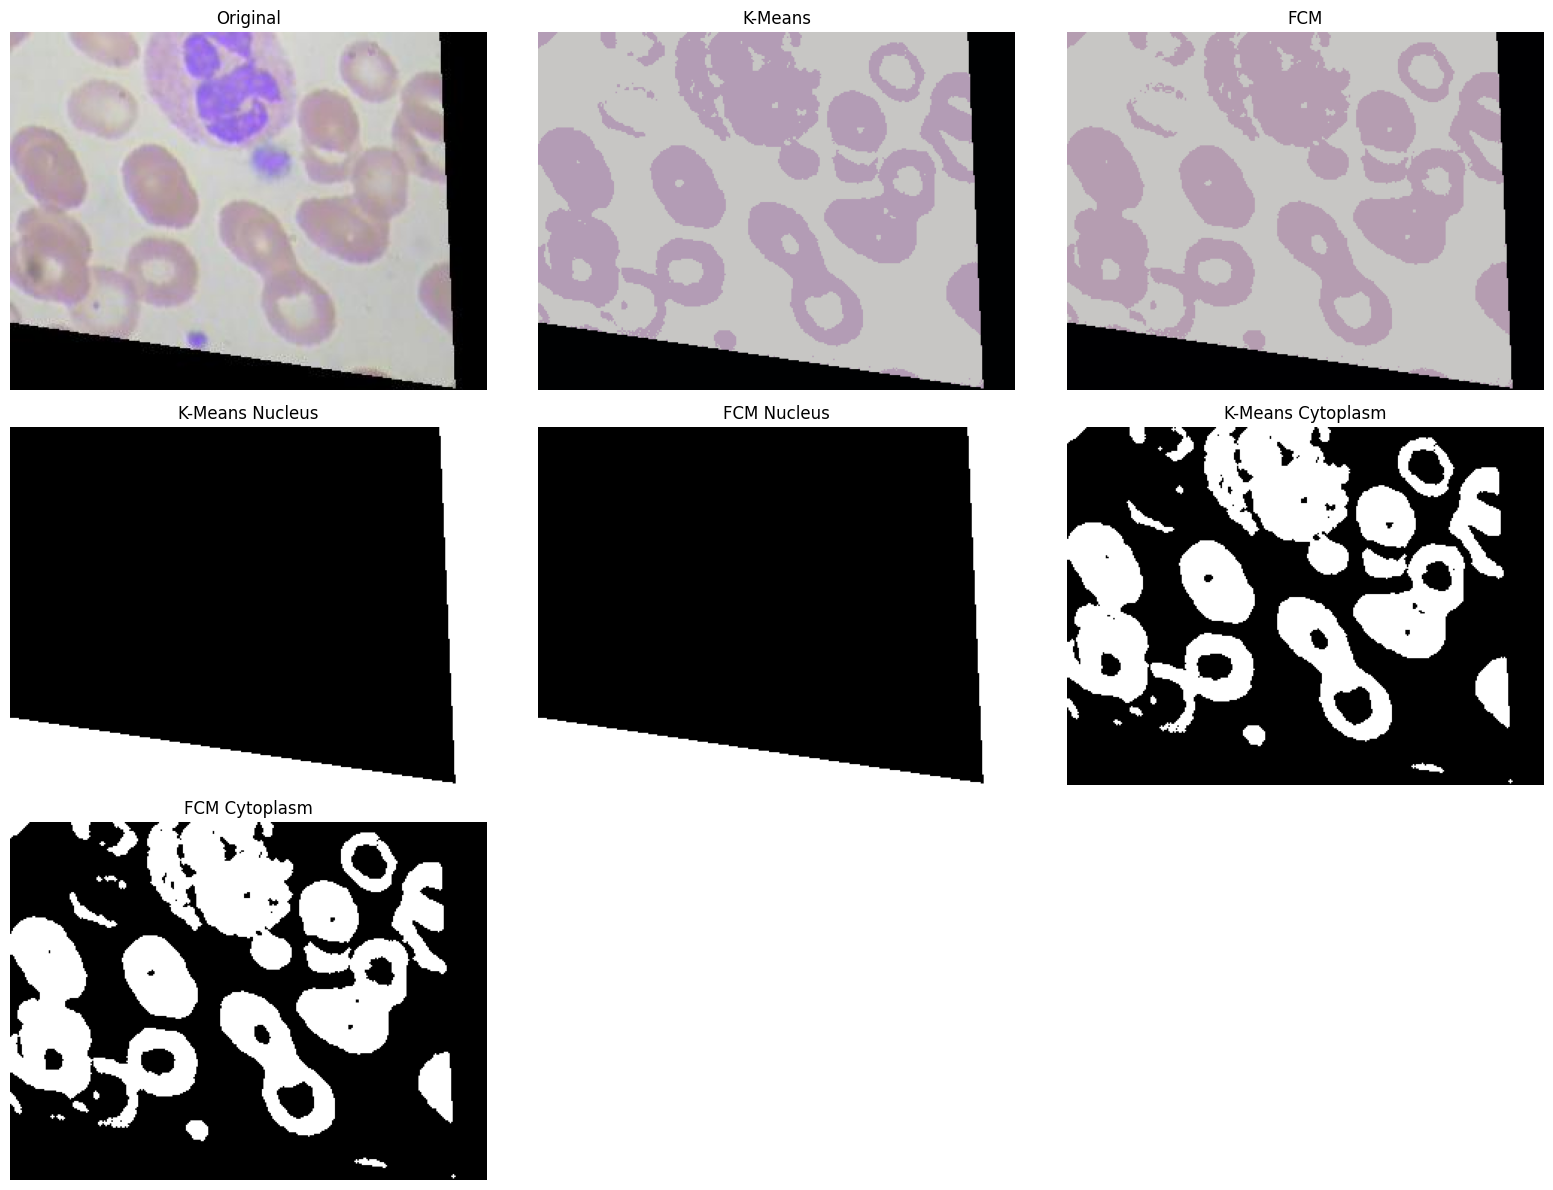

In [10]:
# Set your dataset path (update this!)
DATASET_PATH = 'Blood_Cell_Images/dataset2-master/dataset2-master/images/TRAIN'

# Example single image (choose any)
example_image = os.path.join(DATASET_PATH, 'NEUTROPHIL', '_0_1095.jpeg')

try:
    img, km_res, fcm_res, km_nuc, fcm_nuc, km_cyto, fcm_cyto = segment_wbc(example_image, n_clusters=3)
    
    # Compute edge overlap
    km_edge = edge_overlap(img, km_res)
    fcm_edge = edge_overlap(img, fcm_res)
    
    print(f"Edge overlap (K-Means): {km_edge:.3f}")
    print(f"Edge overlap (FCM): {fcm_edge:.3f}")
    print(f"Better edge alignment: {'K-Means' if km_edge > fcm_edge else 'FCM'}")
    
    # Display results
    plt.figure(figsize=(16, 12))
    
    plt.subplot(3, 3, 1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(3, 3, 2)
    plt.title("K-Means")
    plt.imshow(km_res)
    plt.axis('off')
    
    plt.subplot(3, 3, 3)
    plt.title("FCM")
    plt.imshow(fcm_res)
    plt.axis('off')
    
    plt.subplot(3, 3, 4)
    plt.title("K-Means Nucleus")
    plt.imshow(km_nuc, cmap='gray')
    plt.axis('off')
    
    plt.subplot(3, 3, 5)
    plt.title("FCM Nucleus")
    plt.imshow(fcm_nuc, cmap='gray')
    plt.axis('off')
    
    plt.subplot(3, 3, 6)
    plt.title("K-Means Cytoplasm")
    plt.imshow(km_cyto, cmap='gray')
    plt.axis('off')
    
    plt.subplot(3, 3, 7)
    plt.title("FCM Cytoplasm")
    plt.imshow(fcm_cyto, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error: {e}")

In [11]:
# Get a list of image paths (adjust max_images as needed)
image_paths = get_image_paths(DATASET_PATH, max_images=20)
print(f"Processing {len(image_paths)} images...")

# Data collection
results = []

for i, img_path in enumerate(image_paths):
    try:
        img, km_res, fcm_res, km_nuc, fcm_nuc, km_cyto, fcm_cyto = segment_wbc(img_path, n_clusters=3)
        
        # Compute metrics
        km_edge = edge_overlap(img, km_res)
        fcm_edge = edge_overlap(img, fcm_res)
        km_nuc_size = np.sum(km_nuc)
        fcm_nuc_size = np.sum(fcm_nuc)
        
        # Store in dictionary
        results.append({
            'image': os.path.basename(img_path),
            'km_edge': km_edge,
            'fcm_edge': fcm_edge,
            'km_nuc_size': km_nuc_size,
            'fcm_nuc_size': fcm_nuc_size
        })
        
        if (i+1) % 5 == 0:
            print(f"Processed {i+1}/{len(image_paths)} images")
            
    except Exception as e:
        print(f"Failed on {img_path}: {e}")
        continue

# Convert to DataFrame
df = pd.DataFrame(results)
print("\nBatch processing complete.")

Processing 20 images...
Processed 5/20 images
Processed 10/20 images
Processed 15/20 images
Processed 20/20 images

Batch processing complete.



=== Boundary Edge Overlap ===
K-Means: 0.199 ± 0.065
FCM:      0.210 ± 0.065

=== Nucleus Size (pixels) ===
K-Means: 12447 ± 11789
FCM:      7033 ± 2791

FCM gives higher edge overlap in 16/20 images (80.0%)


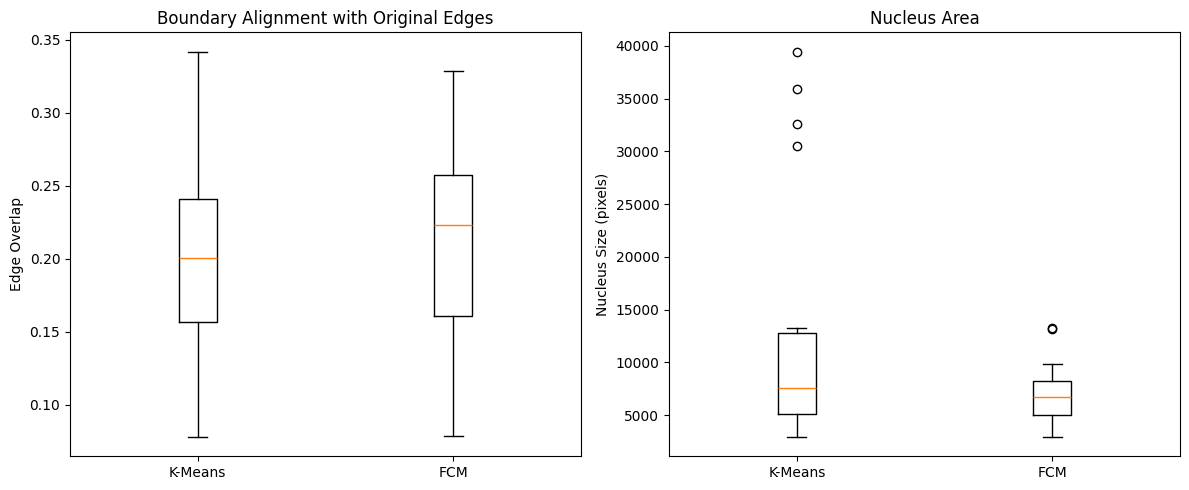

In [14]:
print("\n=== Boundary Edge Overlap ===")
print(f"K-Means: {df['km_edge'].mean():.3f} ± {df['km_edge'].std():.3f}")
print(f"FCM:      {df['fcm_edge'].mean():.3f} ± {df['fcm_edge'].std():.3f}")

print("\n=== Nucleus Size (pixels) ===")
print(f"K-Means: {df['km_nuc_size'].mean():.0f} ± {df['km_nuc_size'].std():.0f}")
print(f"FCM:      {df['fcm_nuc_size'].mean():.0f} ± {df['fcm_nuc_size'].std():.0f}")

# Paired comparison: how often does FCM outperform K-Means?
better_fcm = (df['fcm_edge'] > df['km_edge']).sum()
print(f"\nFCM gives higher edge overlap in {better_fcm}/{len(df)} images ({better_fcm/len(df)*100:.1f}%)")

# Boxplot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].boxplot([df['km_edge'], df['fcm_edge']], labels=['K-Means', 'FCM'])
axes[0].set_ylabel('Edge Overlap')
axes[0].set_title('Boundary Alignment with Original Edges')

axes[1].boxplot([df['km_nuc_size'], df['fcm_nuc_size']], labels=['K-Means', 'FCM'])
axes[1].set_ylabel('Nucleus Size (pixels)')
axes[1].set_title('Nucleus Area')

plt.tight_layout()
plt.show()


## Hard vs Soft Clustering Explanation

### K-Means (Hard Clustering)
- **Hard Assignment**: Each pixel belongs to exactly one cluster.
- **Pros**: Simple, fast, deterministic.
- **Cons**: Sensitive to initialization, may not handle overlapping clusters well.
- **Boundary**: Crisp, sharp edges between clusters.

### Fuzzy C-Means (Soft Clustering)
- **Soft Assignment**: Each pixel has membership degrees to all clusters (values between 0 and 1).
- **Pros**: Handles overlapping clusters better, more flexible.
- **Cons**: Computationally more expensive, requires parameter tuning (fuzziness parameter m).
- **Boundary**: Smoother transitions, potentially better for natural boundaries.

### Boundary Accuracy Comparison
We use gradient magnitude as a proxy for boundary sharpness. Higher values indicate sharper boundaries.
In practice, FCM often produces smoother segmentations that may align better with natural cell boundaries.